In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
%matplotlib notebook
from ipywidgets import interact, IntSlider
from skimage import color
import numpy as np
from numba import vectorize, float64

from color_array import ColorArray
from palette import ColorPalette

In [2]:
np.array((255,0,0)).reshape(1,1,3)

color.rgb2lab(np.array((1.,0,0), ).reshape(1,1,3))

array([[[ 53.24058794,  80.09230823,  67.20275104]]])

In [3]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def lab2hcl(lab):
    hcl = np.copy(lab)
    hcl[..., 2] = hcl[..., 0]
    hcl[..., 1], hcl[..., 0] = cart2pol(lab[..., 1], lab[..., 2])
    return hcl

def hcl2lab(hcl):
    lab = np.copy(hcl)
    lab[..., 0] = lab[..., 2]
    lab[..., 1], lab[..., 2] = pol2cart(hcl[..., 1], hcl[..., 0])
    return lab

def rgb2hcl(rgb):
    lab = color.rgb2lab(rgb)
    hcl = lab2hcl(lab)
    return hcl

def hcl2rgb(hcl):
    lab = hcl2lab(hcl)
    if len(hcl.shape) < 4:
        rgb = color.lab2rgb(lab)
    else:
        rgb = np.stack([color.lab2rgb(lab[i]) for i in range(len(lab))], axis=0)
    return rgb

In [21]:
n = 256
c = np.linspace(0, 134, n)
l = np.linspace(0, 100, n)
h = np.linspace(0, 2*3.14159, n)

hh, cc, ll = np.meshgrid(h,c,l,indexing='ij')
hcl_mesh = ColorArray(np.stack((hh, cc, ll), axis=-1), color_space='hcl')

<IPython.core.display.Javascript object>


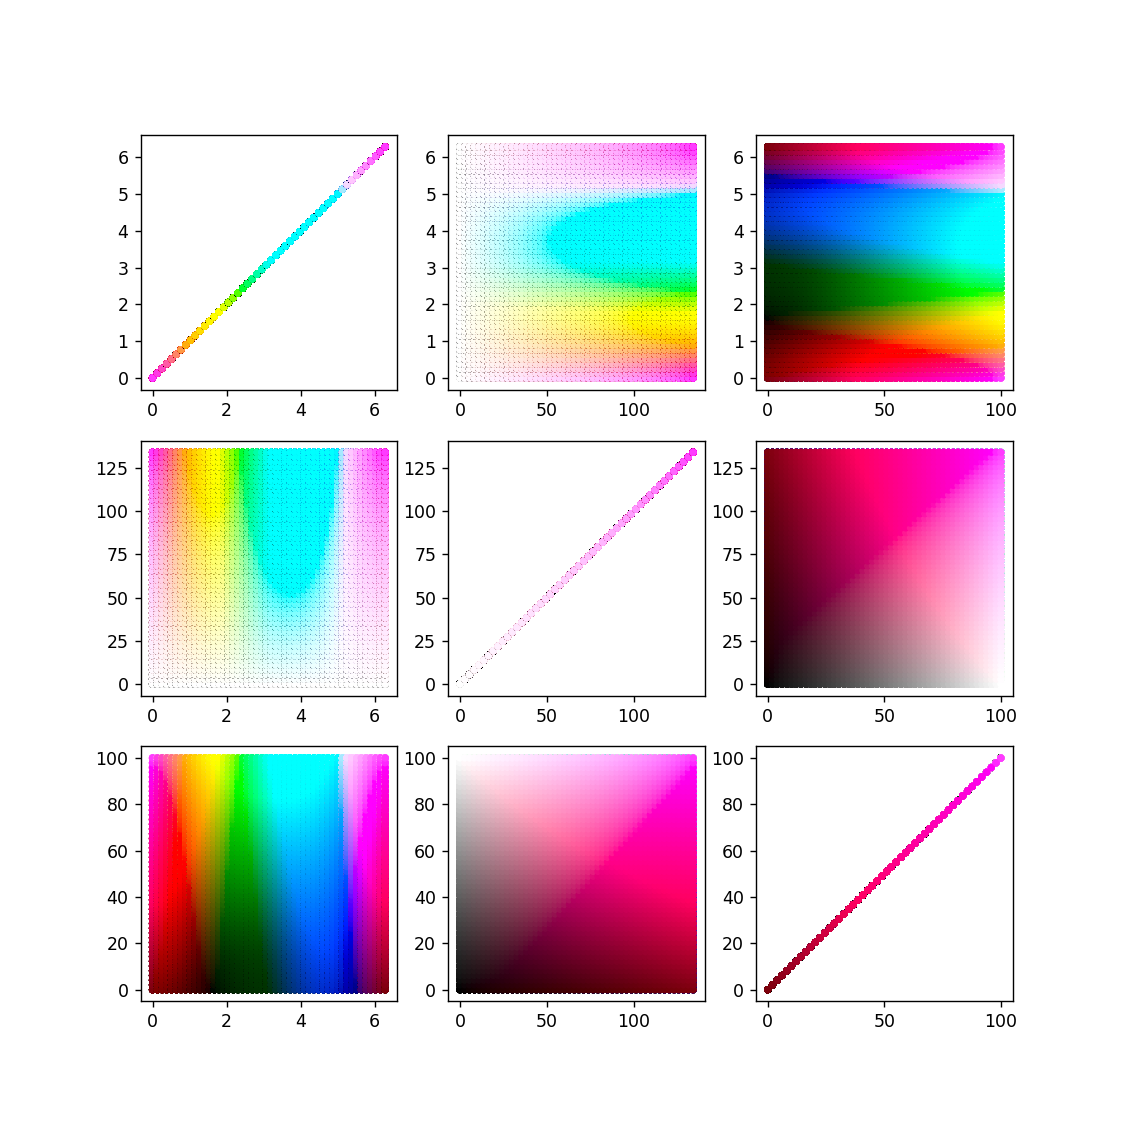

In [5]:
plt.figure(figsize=(9,9))

for i in range(3):
    for j in range(3):
        plt.subplot(3,3,(3)*j + i+1)
        plt.scatter(hcl_mesh[...,i].ravel(), hcl_mesh[...,j].ravel(), s=10, c=rgb_mesh.reshape(-1,3))
plt.show()

In [16]:
hcl_mesh.shape

(256, 256, 256, 3)

<IPython.core.display.Javascript object>


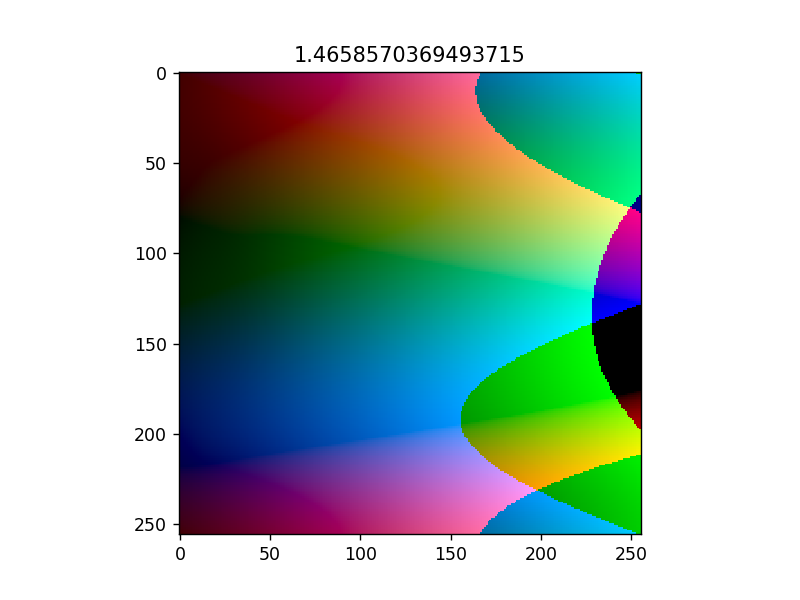

In [32]:
c_fig = plt.figure()

c_sub = c_fig.add_subplot(111)


@interact(c_idx=IntSlider(min=0, max=n-1))
def chroma_replot(c_idx):
    c_sub.clear()
    img = hcl_mesh[:, c_idx].to_rgb()
    img[img < 0] = np.nan
    img[img > 1] = np.nan
    c_sub.imshow(img)
    c_sub.set_title((float(hcl_mesh[..., c_idx, 2].min()), float(hcl_mesh[..., c_idx, 2].max())))
    c_sub.set_title(hcl_mesh[:, c_idx].to_rgb().max())
    plt.show()
    

In [7]:
hcl_mesh[...,0].max()

6.2831799999999998

In [8]:
hh[0,:,0].std()

0.0

In [9]:
ii,jj,kk = np.mgrid[0:3,0:3,0:3]
x = np.arange(3)
y = np.arange(3)
xx = x[ii]

In [10]:
xx

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]])

<IPython.core.display.Javascript object>


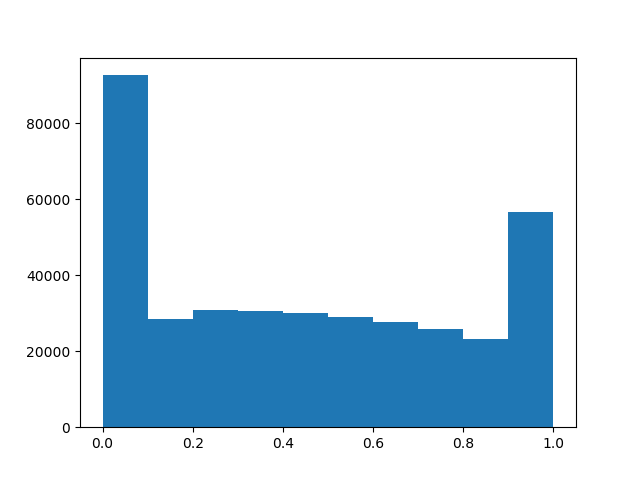

In [11]:
plt.figure()

plt.hist(rgb_mesh.ravel())
plt.show()

In [36]:
@vectorize()
def linearize_srgb(c):
    if c > 0.04045:
        c_linear = ((c + 0.055)/1.055)**2.4
    else:
        c_linear = c/12.92
    return c_linear

@vectorize()
def gamma_correct_srgb(c):
    if c > 0.0031308:
        c_gamma_corrected = 1.055 * (c**(1/2.4)) - 0.055
    else:
        c_gamma_corrected = 12.92*c
    return c_gamma_corrected
        
def rgb2xyz(rgb):
    linear_rgb = linearize_srgb(rgb)
    transformation_matrix = np.array([[0.4124, 0.3576, 0.1805],
                                      [0.2126, 0.7152, 0.0722],
                                      [0.0193, 0.1192, 0.9505]])
    
    reshaped_rgb = linear_rgb.reshape(-1, 3)
    reshaped_xyz = reshaped_rgb @ transformation_matrix.T
    return reshaped_xyz.reshape(rgb.shape)

def xyz2rgb(xyz):
    transformation_matrix = np.array([[ 3.2406, -1.5372, -0.4986],
                                      [-0.9689,  1.8758,  0.0415],
                                      [ 0.0557, -0.2040,  1.0570]])
    reshaped_xyz = xyz.reshape(-1, 3)
    reshaped_rgb = reshaped_xyz @ transformation_matrix.T
    linear_rgb = reshaped_rgb.reshape(xyz.shape)
    rgb = gamma_correct_srgb(linear_rgb)
    return rgb  
    
@vectorize([float64(float64)])
def _lab_f(c):
    delta = 6/29
    
    if c>delta**3:
        return c**(1/3)
    else:
        return c/(3*delta**2) + 4/29
@vectorize([float64(float64)])    
def _lab_f_inverse(c):
    delta = 6/29
    
    if c>delta:
        return c**3
    else:
        return 3*delta**2*(c-4/29)

def xyz2lab(xyz):
    X_n = 95.047/100
    Y_n = 100/100
    Z_n = 108.883/100
    
    x = xyz[..., 0]
    y = xyz[..., 1]
    z = xyz[..., 2]
    
    lab = np.empty_like(xyz)
    lab[..., 0] = 116*_lab_f(y/Y_n) - 16
    lab[..., 1] = 500*(_lab_f(x/X_n) - _lab_f(y/Y_n))
    lab[..., 2] = 200*(_lab_f(y/Y_n) - _lab_f(z/Z_n))
    
    return lab

def lab2xyz(lab):
    X_n = 95.047/100
    Y_n = 100/100
    Z_n = 108.883/100
    
    L = lab[..., 0]
    a = lab[..., 1]
    b = lab[..., 2]
    
    xyz = np.empty_like(lab)
    
    L_ = (L + 16)/116
    xyz[..., 0] = X_n*_lab_f_inverse(L_ + a/500)
    xyz[..., 1] = Y_n*_lab_f_inverse(L_)
    xyz[..., 2] = Z_n*_lab_f_inverse(L_ - b/200)
    
    return xyz

def rgb2lab(rgb):
    xyz = rgb2xyz(rgb)
    lab = xyz2lab(xyz)
    
    return lab

def lab2rgb(lab):
    xyz = lab2xyz(lab)
    rgb = xyz2rgb(xyz)
    
    return rgb


